In [1]:
%%capture
!pip install langchain-community pypdf
!pip install -qU langchain-huggingface
!pip install -U langchain-google-genai
!pip install "unstructured[image]"
!pip install pillow opencv-python
!pip install tqdm
!pip install ddgs
!pip install -U langchain langchain-community langchain-core

In [2]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()


··········


In [ ]:
#SmartLoader

In [3]:

import os, requests
from langchain_community.document_loaders import (
    PyPDFLoader,
    CSVLoader,
    WebBaseLoader,
)

def smart_loader(source: str):
    """Load documents from file path or URL intelligently."""
    all_docs = []

    if source.startswith("http://") or source.startswith("https://"):
        # Web link
        if source.endswith(".pdf"):
            # Download PDF temporarily
            temp_path = "temp.pdf"
            response = requests.get(source)
            with open(temp_path, "wb") as f:
                f.write(response.content)
            loader = PyPDFLoader(temp_path)
            all_docs.extend(loader.load())
            os.remove(temp_path)
        elif source.endswith(".csv"):
            temp_path = "temp.csv"
            response = requests.get(source)
            with open(temp_path, "wb") as f:
                f.write(response.content)
            loader = CSVLoader(file_path=temp_path)
            all_docs.extend(loader.load())
            os.remove(temp_path)
        else:
            # Generic webpage
            loader = WebBaseLoader(source)
            all_docs.extend(loader.load())
    else:
        # Local file
        if source.endswith(".pdf"):
            loader = PyPDFLoader(file_path=source)
        elif source.endswith(".csv"):
            loader = CSVLoader(file_path=source)
        else:
            raise ValueError(f"Unsupported file format: {source}")
        all_docs.extend(loader.load())

    return all_docs


Chunking Function

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
def load_and_split_data(source: str, chunk_size: int = 1000, chunk_overlap: int = 400):
    """
    Load documents from a file path or URL using smart_loader,
    then split them into manageable text chunks.
    """
    # Load documents (smart detection)
    all_docs = smart_loader(source)

    # Split into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        add_start_index=True,
    )
    all_splits = text_splitter.split_documents(all_docs)

    print(f"✅ Loaded {len(all_docs)} documents, split into {len(all_splits)} chunks.")
    return all_docs, all_splits

Embedding Function

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name="minishlab/potion-base-8M")
from tqdm import tqdm

# Assuming you already have this function from before:
# from your_module import load_and_split_data

def generate_embeddings_from_source(source: str, embeddings_model=None):
    """
    Loads, splits, and embeds text from a file or URL.
    Returns: (documents, splits, vectors)
    """
    # Step 1: Load and split the data
    all_docs, all_splits = load_and_split_data(source)

    # Step 2: Initialize embedding model if not provided
    embeddings = embeddings_model or embedding_model

    # Step 3: Generate embeddings
    all_vectors = []
    for doc in tqdm(all_splits, desc="Generating embeddings"):
        vec = embeddings.embed_query(doc.page_content)
        all_vectors.append(vec)

    print(f"\n✅ Loaded {len(all_docs)} documents")
    print(f"✅ Split into {len(all_splits)} chunks")
    print(f"✅ Generated {len(all_vectors)} embeddings.")

    return all_docs, all_splits, all_vectors

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/278 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

./model.safetensors:   0%|          | 0.00/30.2M [00:00<?, ?B/s]

In [6]:
%%capture
!pip install -qU langchain-chroma

In [ ]:
import chromadb
from langchain_chroma import Chroma
from datetime import datetime
from tqdm import tqdm

# Reuse global embedding model and client
from langchain_huggingface import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name="minishlab/potion-base-8M")

cloud_client = chromadb.CloudClient(
    api_key="",
    tenant="",
)
global_vector_store = None
# 🧩 Combine everything
def add_source_to_vector_db(
    source: str,
    collection_name: str,
    embeddings_model=embedding_model,
    client=cloud_client,
    batch_size: int = 300
):
    """
    Loads, splits, embeds, and uploads data from any source (PDF/local/URL) to Chroma Cloud.
    """

    print(f"\n📄 Processing source: {source}")

    # Step 1: Generate docs, splits, vectors using your pipeline
    docs, splits, vectors = generate_embeddings_from_source(source, embeddings_model)

    print(f"✅ Loaded {len(docs)} documents | Split into {len(splits)} chunks")

    # Step 2: Connect or create Chroma collection
    vector_store = Chroma(
        client=client,
        collection_name=collection_name,
        embedding_function=embeddings_model,
    )
    global global_vector_store
    global_vector_store = vector_store

    # Step 3: Add chunks in batches
    ids = []
    for i in tqdm(range(0, len(splits), batch_size), desc="Uploading to Chroma"):
        batch = splits[i:i+batch_size]
        for doc in batch:
            doc.metadata.setdefault("source", source)
            doc.metadata.setdefault("upload_date", str(datetime.now()))
        try:
            batch_ids = vector_store.add_documents(documents=batch)
            ids.extend(batch_ids)
        except Exception as e:
            print(f"⚠️ Error adding batch {i//batch_size + 1}: {e}")

    print(f"\n✅ Successfully uploaded {len(ids)} chunks from {source} → {collection_name}")

    return ids, vector_store

In [ ]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI # Changed import

os.environ["GOOGLE_API_KEY"] = ""

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite") # Changed instantiation

In [9]:
from langchain.tools import tool
def add_data_to_vector_db(sources: list[str], collection_name: str):
    """
    Takes a list of data sources (PDF paths or URLs) and a collection name,
    and adds them to ChromaDB.
    """
    if not collection_name:
        return "❌ Please specify a collection name."

    results = []
    for src in sources:
        try:
            ids, vector_store = add_source_to_vector_db(src, collection_name)
            results.append(f"✅ Added {len(ids)} chunks from {src}")
        except Exception as e:
            results.append(f"❌ Failed for {src}: {e}")
    return "\n".join(results)


Mode2 only for STI Graph

In [ ]:
from langchain.tools import tool

@tool("data_ingestion_workflow", return_direct=True)
def data_ingestion_workflow(
    external_sources: list[str] = None,
    external_collection: str = None
):
    """
    Data ingestion workflow — External Ingestion Only.

    Usage:
    - Requires both external_sources (list of file URLs/paths)
      and external_collection (string collection name).
    - Returns data ingestion result.

    Example:
    data_ingestion_workflow.invoke({
        "external_sources": ["file1.pdf", "https://example.com/paper.pdf"],
        "external_collection": "AI_Papers"
    })
    """

    # --------------------------------------
    
    
    if external_sources and external_collection:
        print("📥 Running in EXTERNAL INGESTION MODE...")
        print("Sources received:", external_sources)
        print("Collection name:", external_collection)

        result = add_data_to_vector_db(external_sources, external_collection)

        return {
            "message": "External ingestion completed.",
            "result": result,
        }

    # If input is incorrect or incomplete
    return {
        "error": "Missing required parameters. Please provide 'external_sources' and 'external_collection'.",
        "example": {
            "external_sources": ["file.pdf", "https://link.com/paper.pdf"],
            "external_collection": "MyCollection"
        }
    }


In [11]:
%%capture
!pip install ddgs serper playwright beautifulsoup4 lxml aiohttp
!pip install python-docx
!playwright install
!pip install langchain

In [ ]:
from langchain.tools import tool
from ddgs import DDGS
import requests
from docx import Document
from datetime import datetime

SERPER_API_KEY = ""


def ddg_text_search(query, max_results=15):
    results = []
    try:
        with DDGS() as ddgs:
            for r in ddgs.text(query, max_results=max_results):
                results.append({
                    "title": r.get("title"),
                    "snippet": r.get("body"),
                    "link": r.get("href"),
                    "source": "ddg"
                })
    except:
        pass
    return results


def serper_text_search(query, max_results=15):
    try:
        payload = {"q": query, "num": max_results}
        headers = {"X-API-KEY": SERPER_API_KEY, "Content-Type": "application/json"}

        res = requests.post("https://google.serper.dev/search", json=payload, headers=headers)
        organic = res.json().get("organic", [])

        return [{
            "title": r.get("title"),
            "snippet": r.get("snippet"),
            "link": r.get("link"),
            "source": "google-serper"
        } for r in organic]
    except:
        return []


def rank(results):
    _priority = {"google-serper": 1, "ddg": 2}
    return sorted(results, key=lambda x: _priority.get(x["source"], 9))



def unified_search(query, max_results=15):

    # TEXT SEARCH
    ddg_text = ddg_text_search(query, max_results)
    google_text = serper_text_search(query, max_results)

    # Combine & rank
    all_text = rank(ddg_text + google_text)[:max_results]

    return all_text



def save_links_to_docx(query, results, file_path):
    doc = Document()

    doc.add_heading(f"Top Search Links for: {query}", level=1)
    doc.add_paragraph(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    # LINKS ONLY (no numbers, plain list)
    doc.add_heading("Links", level=2)

    if not results:
        doc.add_paragraph("No results found.")
    else:
        for r in results:
            doc.add_paragraph(r)

    doc.save(file_path)
    return file_path



# ---------------------------------------------------------
def unified_search_and_export(query, max_results=15):
    # unified_search returns ONLY text results now
    text_results = unified_search(query, max_results)
    return text_results

@tool("unified_web_search", return_direct=False)
def unified_web_search_tool(query: str, max_results: int = 15) -> dict:
    """
    Performs unified DuckDuckGo + Google Serper text search.
    Returns top links in a structured dict (no saving here).
    """

    # Get search results
    text_results = unified_search_and_export(
        query=query,
        max_results=max_results
    )

    links = [r["link"] for r in text_results]

    return {
        "query": query,
        "count": len(links),
        "links": links
    }


@tool("save_links_to_docx", return_direct=True)
def save_links_to_docx_tool(query: str, links: list, file_path: str) -> str:
    """
    Saves a list of search links to a DOCX file.
    """
    if not links:
        return "❌ No links provided to save."

    path = save_links_to_docx(query, links, file_path)
    print("The Search Results are saved")

    return f"📄 Links saved successfully to: {path}"




@tool("interactive_search_and_save", return_direct=True)
def interactive_search_and_save() -> str:
    """
    Fully interactive loop:
    - Ask the user what they want to search
    - Show results
    - Ask if they want to save (all or selected)
    - Save links to DOCX
    - Keep updating until user says 'done'
    """

    docx_path = "interactive_search_results.docx"
    all_saved_links = []

    while True:
        # Step 1: Ask for search query
        user_query = input("\n🔍 Enter your search query (or type 'done' to exit): ").strip()
        if user_query.lower() == "done":
            return {
                  "links": all_saved_links
                    }

        # Step 2: Search
        result = unified_web_search_tool.invoke({
            "query": user_query,
            "max_results": 15
        })

        print("\n--- Search Results ---")
        print(result)

        # Parse links back from text
        links = result["links"]

        # Step 3: Ask user if they want to save
        save_choice = input(
            "\n💾 Do you want to save links?\n"
            "(all / selected / no): "
        ).strip().lower()

        if save_choice == "no":
            print("Skipping save.")
            continue

        # Step 4: Save all links
        if save_choice == "all":
            all_saved_links.extend(links)
            save_links_to_docx("Combined Search Results", all_saved_links, docx_path)
            print(f"✔️ Saved all {len(all_saved_links)} total links.")
            continue

        # Step 5: Save selected links
        if save_choice == "selected":
            print("\nEnter indices of links you want to save (comma-separated):")
            for idx, link in enumerate(links):
                print(f"{idx}. {link}")

            selected_input = input("Your selection: ").strip()
            try:
                indices = [int(x.strip()) for x in selected_input.split(",")]
                selected_links = [links[i] for i in indices if 0 <= i < len(links)]
                all_saved_links.extend(selected_links)
                save_links_to_docx("Combined Search Results", all_saved_links, docx_path)
                print(f"✔️ Saved selected links ({len(selected_links)} added).")
            except:
                print("❌ Invalid selection. Skipping.")

        else:
            print("❌ Invalid choice. Skipping.")

    # End




In [ ]:
#####GRAPHS#########

In [ ]:
%%capture
!pip install langgraph
from langgraph.graph import StateGraph

In [ ]:
from typing import TypedDict, List, Optional, Dict, Any
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
import ast

class IngestionState(TypedDict):
    messages: List[Any]
    sources: Optional[List[str]]
    collection_name: Optional[str]
    ingestion_result: Optional[Dict[str, Any]]
    continue_loop: bool
    ingestion_completed: bool

# ---------------- Nodes ----------------

def interactive_node(state: IngestionState) -> Dict[str, Any]:
    msgs = state.get("messages", [])
    if not msgs:
        return {
            "messages": [AIMessage(content="Please provide sources and collection name.")],
            "continue_loop": True,
            "next": "INTERACTIVE"
        }

    last = msgs[-1].content.lower().strip()

    if last in ("done", "exit", "finish", "quit", "stop"):
        return {
            "messages": msgs + [AIMessage(content="❌ Ingestion canceled by user.")],
            "continue_loop": False,
            "ingestion_completed": False,
            "next": "__end__"
        }

    prompt = (
        "You are a structured input generator for data ingestion.\n\n"
        "Extract two items from the user query:\n"
        "1) A Python list of URLs/PDF paths (e.g. [\"/path/a.pdf\", \"http://...\"])\n"
        "2) A Python string specifying the collection name (e.g. \"AI_Research\")\n\n"
        "Return exactly two lines (no markdown):\n"
        '["/path/a.pdf", "https://..."]\n"Collection_Name"\n'
    )

    llm_resp = model.invoke(prompt + "\nUser:\n" + msgs[-1].content)

    return {
        "messages": msgs + [llm_resp],
        "continue_loop": True,
        "next": "PARSE"
    }

def parse_node(state: IngestionState) -> Dict[str, Any]:
    msgs = state.get("messages", [])
    llm_text = msgs[-1].content

    lines = [line.strip() for line in llm_text.splitlines() if line.strip()]

    try:
        sources = ast.literal_eval(lines[0])
        collection_name = ast.literal_eval(lines[1])
        return {
            "sources": sources,
            "collection_name": collection_name,
            "continue_loop": True,
            "next": "INGEST"
        }
    except Exception:
        return {
            "messages": msgs + [AIMessage(content="⚠ Could not parse. Please provide valid input.")],
            "continue_loop": True,
            "next": "INTERACTIVE"
        }

def ingestion_node(state: IngestionState) -> Dict[str, Any]:
    sources = state.get("sources") or []
    collection = state.get("collection_name") or "default_collection"
    result = add_data_to_vector_db(sources, collection)

    return {
        "messages": state.get("messages", []) + [AIMessage(content=f"✔ Data ingested to collection: {collection}")],
        "ingestion_result": result,
        "ingestion_completed": True,
        "continue_loop": False,
        "next": "__end__"
    }

# ---------------- Build Graph ----------------

graph = StateGraph(IngestionState)

graph.add_node("INTERACTIVE", interactive_node)
graph.add_node("PARSE", parse_node)
graph.add_node("INGEST", ingestion_node)
graph.set_entry_point("INTERACTIVE")

graph.add_edge("INTERACTIVE", "PARSE")
graph.add_edge("PARSE", "INGEST")
graph.add_edge("INGEST", END)

ingestion_graph = graph.compile()




📄 Processing source: /content/Paper_86-Cardio_Edge_Hardware_Software_Co_design_Implementation.pdf

🎯 FINAL RESULT:
{'messages': [HumanMessage(content='Please add /content/Paper_86-Cardio_Edge_Hardware_Software_Co_design_Implementation.pdf into AI_Knowledge7', additional_kwargs={}, response_metadata={}), AIMessage(content='["/content/Paper_86-Cardio_Edge_Hardware_Software_Co_design_Implementation.pdf"]\n"AI_Knowledge7"', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--adbbfb09-cbf6-4df7-b538-448bb2a9fad5-0', usage_metadata={'input_tokens': 133, 'output_tokens': 33, 'total_tokens': 166, 'input_token_details': {'cache_read': 0}}), AIMessage(content='✔ Data ingested to collection: AI_Knowledge7', additional_kwargs={}, response_metadata={})], 'sources': ['/content/Paper_86-Cardio_Edge_Hardware_Software_Co

In [ ]:
###########SEACH to INGESTION PIPELINE Graph#########################

In [38]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict

# ----- Define Pipeline State -----
class PipelineState(TypedDict):
    links: List[str]
    ingestion_result: Dict
    collection_name: str
    run_rag: bool


# ----- Node 1: Search -----
def search_node(state: PipelineState):
    search_output = interactive_search_and_save.invoke({})
    if "links" not in search_output or not search_output["links"]:
        return {
            "links": [],
            "collection_name": state["collection_name"],
            "run_rag": state["run_rag"]
        }  # exit condition
    return {
        "links": search_output["links"],
        "collection_name": state["collection_name"],
        "run_rag": state["run_rag"]
    }


# ----- Node 2: Ingestion -----
def ingestion_node(state: PipelineState):
    if not state["run_rag"]:
        return {
            "ingestion_result": {"message": "RAG skipped"},
            "links": state["links"],
            "collection_name": state["collection_name"]
        }

    ingestion_result = data_ingestion_workflow.invoke({
        "external_sources": state["links"],
        "external_collection": state["collection_name"]
    })

    return {
        "links": state["links"],
        "collection_name": state["collection_name"],
        "ingestion_result": ingestion_result
    }


# ----- Build Graph -----
graph = StateGraph(PipelineState)

graph.add_node("SEARCH", search_node)
graph.add_node("INGESTION", ingestion_node)

graph.set_entry_point("SEARCH")

# Conditional flow
graph.add_conditional_edges(
    "SEARCH",
    lambda state: "__end__" if not state["links"] else "INGESTION",
    {
        "INGESTION": "INGESTION",
        "__end__": END
    }
)

graph.set_finish_point("INGESTION")

search_ingestion_workflow = graph.compile()

# Orchestrator Graph

In [33]:
from typing import TypedDict, Optional, List, Dict, Any
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END


# 🟦 Define Orchestrator State
class OrchestratorState(TypedDict):
    messages: List[Any]
    user_choice: Optional[int]  # 1 or 2
    links: Optional[List[str]]
    collection_name: Optional[str]
    final_result: Optional[Dict]


# 🧠 Decision Node
def decision_node(state: OrchestratorState):
    user_choice = state.get("user_choice")
    print(f"🧠 Decision Node -> User selected option: {user_choice}")

    if user_choice == 1:
        print("📦 Route to ingestion_graph")
        return {"next": "run_ingestion"}   # <-- FIXED
    elif user_choice == 2:
        print("🔍 Route to search_ingestion_workflow")
        return {"next": "run_search"}      # <-- FIXED
    else:
        print("❌ Invalid selection!")
        return {"next": "invalid_choice"}  # <-- FIXED


# 📦 Run ingestion_graph (Local or predefined data)
def run_ingestion_node(state):
    print("🚀 Running ingestion_graph...")

    initial_state = IngestionState(
        messages=[HumanMessage(content=state["messages"][-1].content)],
        sources=None,
        collection_name=None,
        ingestion_result=None,
        continue_loop=True,
        ingestion_completed=False
    )

    result_state = ingestion_graph.invoke(initial_state)
    print("\n🎯 FINAL RESULT:")
    print(result_state)

    return {"final_result": result_state}



# 🔍 Run search_ingestion_workflow (Online search mode)
def run_search_node(state: OrchestratorState):
    print("🔎 Running search_ingestion_workflow...")
    pipeline_state = {
        "links": [],
        "collection_name": "search_results",
        "run_rag": True
          }

    result = search_ingestion_workflow.invoke(pipeline_state)

    # 🔥 Only pass links, collection will be handled later
    return {
        "final_result": result,
        "links": result.get("links"),  # extract from search output
        "collection_name": None        # ❌ no collection name yet
    }




# ❌ Invalid choice
def invalid_choice_node(state: OrchestratorState):
    print("🛑 Stopping: Invalid user selection!")
    return {"final_result": "❌ Invalid choice! Please select 1 or 2."}


# 🏗 Build Graph
data_orchestrator_graph = StateGraph(OrchestratorState)

# Nodes
data_orchestrator_graph.add_node("decision", decision_node)
data_orchestrator_graph.add_node("run_ingestion", run_ingestion_node)
data_orchestrator_graph.add_node("run_search", run_search_node)
data_orchestrator_graph.add_node("invalid_choice", invalid_choice_node)

# Entry
data_orchestrator_graph.set_entry_point("decision")

# Edges
data_orchestrator_graph.add_conditional_edges(
    "decision",
    lambda out: out["next"],  # <-- use "next" from dict
    {
        "run_ingestion": "run_ingestion",
        "run_search": "run_search",
        "invalid_choice": "invalid_choice",
    }
)

# Finish points
data_orchestrator_graph.set_finish_point("run_ingestion")
data_orchestrator_graph.set_finish_point("run_search")
data_orchestrator_graph.set_finish_point("invalid_choice")

# Compile graph
data_orchestrator_graph = data_orchestrator_graph.compile()


In [44]:
from langchain_core.messages import HumanMessage

def run_interactive():
    print("\n🎬 Starting Interactive Orchestrator Tester\n")

    # Initial state
    state = OrchestratorState(
        messages=[],
        user_choice=None,
        links=None,
        collection_name=None,
        final_result=None
    )

    while True:
        # Ask for mode first
        try:
            user_choice = int(input("\n📌 Choose mode\n1️⃣ Local / Existing Data\n2️⃣ Online Search & Ingestion\n👉 Enter 1 or 2 (or 0 to exit): "))
        except ValueError:
            print("❌ Invalid input! Enter 1 or 2.")
            continue

        if user_choice == 0:
            print("👋 Exiting interactive runner.")
            break

        if user_choice not in [1, 2]:
            print("❌ Invalid choice! Please enter 1 or 2.")
            continue

        state["user_choice"] = user_choice

        # Now get the user message
        user_input = input("\n🧑‍💻 Enter your command/message (or type 'exit' to quit):\n")
        if user_input.lower() in ["exit", "quit"]:
            print("👋 Exiting interactive runner.")
            break

        # Add message to graph state
        state["messages"].append(HumanMessage(content=user_input))

        print("\n🔁 Executing Orchestrator graph...")
        result = data_orchestrator_graph.invoke(state)

        print("\n🎯 Final Result:")
        print(result.get("final_result"))

        # Keep state
        state["messages"].append(HumanMessage(content=str(result.get("final_result"))))
        state["final_result"] = result.get("final_result")

        # Continue?
        cont = input("\n🔄 Do another test? (y/n): ")
        if cont.lower() != "y":
            print("🏁 Interactive session completed.")
            break

# Run the interactive tester
run_interactive()



🎬 Starting Interactive Orchestrator Tester


📌 Choose mode
1️⃣ Local / Existing Data
2️⃣ Online Search & Ingestion
👉 Enter 1 or 2 (or 0 to exit): 1

🧑‍💻 Enter your command/message (or type 'exit' to quit):
/content/Paper_86-Cardio_Edge_Hardware_Software_Co_design_Implementation.pdf  into tester collection

🔁 Executing Orchestrator graph...
🧠 Decision Node -> User selected option: 1
📦 Route to ingestion_graph
🚀 Running ingestion_graph...

📄 Processing source: /content/Paper_86-Cardio_Edge_Hardware_Software_Co_design_Implementation.pdf
✅ Loaded 13 documents, split into 99 chunks.


Generating embeddings: 100%|██████████| 99/99 [00:00<00:00, 573.76it/s]


✅ Loaded 13 documents
✅ Split into 99 chunks
✅ Generated 99 embeddings.
✅ Loaded 13 documents | Split into 99 chunks



Uploading to Chroma: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]



✅ Successfully uploaded 99 chunks from /content/Paper_86-Cardio_Edge_Hardware_Software_Co_design_Implementation.pdf → tester

🎯 FINAL RESULT:
{'messages': [HumanMessage(content='/content/Paper_86-Cardio_Edge_Hardware_Software_Co_design_Implementation.pdf  into tester collection', additional_kwargs={}, response_metadata={}), AIMessage(content='["/content/Paper_86-Cardio_Edge_Hardware_Software_Co_design_Implementation.pdf"]\n"tester"', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--974948ce-30b8-4913-a4f2-0aae0e596851-0', usage_metadata={'input_tokens': 130, 'output_tokens': 30, 'total_tokens': 160, 'input_token_details': {'cache_read': 0}}), AIMessage(content='✔ Data ingested to collection: tester', additional_kwargs={}, response_metadata={})], 'sources': ['/content/Paper_86-Cardio_Edge_Hardware_Soft

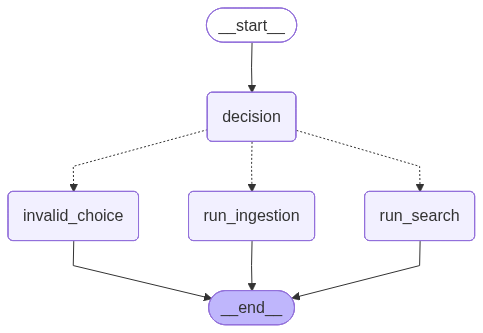

In [53]:
from IPython.display import Image, display
display(Image(data_orchestrator_graph.get_graph().draw_mermaid_png()))

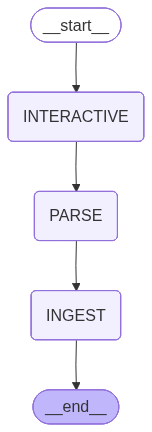

In [54]:
from IPython.display import Image, display
display(Image(ingestion_graph.get_graph().draw_mermaid_png()))

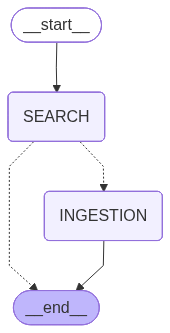

In [55]:
from IPython.display import Image, display
display(Image(search_ingestion_workflow.get_graph().draw_mermaid_png()))

In [47]:
vector_store

R&A Agentic Workflow


In [19]:
from langchain.tools import tool
from ddgs import DDGS
import re
from pypdf import PdfReader
from docx import Document
from docx.shared import Pt, Inches
import os
from datetime import datetime


@tool(response_format="content_and_artifact")
def retrieve_context(query: str, k: int = 3):
    """Retrieve top-k relevant contexts from uploaded research papers."""
    retrieved_docs = vector_store.similarity_search(query, k=k)
    serialized = "\n\n---\n\n".join(
        (
            f"📄 Source: {doc.metadata.get('title', 'Unknown')}\n"
            f"Similarity: {doc.metadata.get('score', 'N/A')}\n"
            f"{doc.page_content}"
        )
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs



#______________________________________

@tool("chroma_pdf_summarizer", return_direct=True)
def chroma_pdf_summarizer(pdf_name: str) -> str:
    """
    Summarizes an already-embedded research paper from ChromaDB.
    Allows partial match, file name, or full path.
    """

    print(f"📚 Searching ChromaDB for embedded content matching: {pdf_name}")

    vectorstore = vector_store

    # Pull all docs + metadata (Chroma does NOT support regex or partial filter)
    raw = vectorstore.get()

    documents = raw.get("documents", [])
    metadatas = raw.get("metadatas", [])

    if not documents:
        return "⚠️ Vector store is empty. Add data first."

    # --- MATCH BY: partial filename, full filename, or full path ---
    matched_docs = []
    matched_sources = set()

    for doc, meta in zip(documents, metadatas):
        source_meta = meta.get("source", "").lower()
        if pdf_name.lower() in source_meta:      # partial substring match
            matched_docs.append(doc)
            matched_sources.add(meta.get("source", "Unknown"))

    if not matched_docs:
        return (
            f"⚠️ No data found for '{pdf_name}'.\n"
            "💡 Tip: Try passing part of the filename instead of the full path.\n"
        )

    print(f"🧩 Matched {len(matched_docs)} chunks from:")
    for src in matched_sources:
        print("   -", src)

    combined_text = "\n".join(matched_docs)

    prompt = f"""
You are a professional AI research summarizer.
Summarize the following research paper content into structured sections:
- Title
- Abstract
- Introduction
- Methodology
- Results / Findings
- Conclusion

Return clean JSON (no markdown).
Content:
{combined_text}
"""

    print("🧠 Generating structured summary using LLM...")
    response = model.invoke(prompt)

    print("✅ Summary generation complete.")
    return response.content.strip()


#----------------------------------------------------------------

def extract_citations_from_pdf(pdf_path: str) -> dict:
    """
    Pure Python function that extracts:
    - inline citations
    - reference entries
    - DOIs
    """

    reader = PdfReader(pdf_path)
    full_text = ""

    # Extract all text
    for page in reader.pages:
        page_text = page.extract_text() or ""
        full_text += page_text + "\n"

    # -----------------------------
    # 1️⃣ EXTRACT INLINE CITATIONS
    # -----------------------------

    inline_patterns = [
        r"\(([^()]+?,\s?\d{4}[a-z]?)\)",        # (Smith, 2020)
        r"[A-Z][A-Za-z]+ et al\.,?\s?\d{4}",    # Smith et al., 2021
        r"[A-Z][A-Za-z]+ and [A-Z][A-Za-z]+,?\s?\d{4}",  # Smith and John, 2019
        r"\[\d{1,3}\]"                           # [1], [12], etc.
    ]

    inline_citations = set()
    for pattern in inline_patterns:
        found = re.findall(pattern, full_text)
        for item in found:
            inline_citations.add(item.strip())

    inline_citations = list(inline_citations)

    # -----------------------------
    # 2️⃣ EXTRACT REFERENCE SECTION
    # -----------------------------

    # Locate "References" or "Bibliography"
    match = re.search(r"(References|Bibliography)(.*)", full_text, re.S | re.I)
    if match:
        ref_section = match.group(2)
    else:
        ref_section = full_text  # fallback

    # Split into entries (numbered, bullet, dash)
    ref_entries = re.split(
        r"\n\d{1,3}\.\s|\n\[\d{1,3}\]\s|\n•\s|\n-\s",
        ref_section
    )

    # Clean entries
    ref_entries = [
        entry.strip()
        for entry in ref_entries
        if len(entry.strip()) > 20
    ]

    # -----------------------------
    # 3️⃣ EXTRACT DOIs
    # -----------------------------

    doi_pattern = r"(10\.\d{4,9}/[-._;()/:A-Za-z0-9]+)"
    dois = list(set(re.findall(doi_pattern, full_text)))

    # -----------------------------
    # RETURN STRUCTURED RESULT
    # -----------------------------

    return {
        "inline_citations": inline_citations,
        "reference_entries": ref_entries,
        "dois": dois
    }



#--------------------------

@tool("extract_references_only", return_direct=True)
def extract_references_only(pdf_path: str) -> list:
    """
    Extract only the reference entries from a PDF using the internal parser.

    Args:
        pdf_path (str): Path to the research paper PDF.

    Returns:
        list: Clean list of reference entries.
    """
    try:
        result = extract_citations_from_pdf(pdf_path)

        reference_list = result.get("reference_entries", [])

        # Make list pretty and safe
        clean_list = [
            ref.replace("\n", " ").strip()
            for ref in reference_list
            if len(ref.strip()) > 5
        ]

        return clean_list

    except Exception as e:
        return {f"Error extracting references: {str(e)}"}


#----------------------------------------------

@tool("summary_to_docx", return_direct=True)
def summary_to_docx(summary_text: str, file_name: str = "Research_Summary.docx") -> str:
    """
    Takes a structured summary text and stores it beautifully in a formatted DOCX file.
    Input:
        - summary_text: The summary content (JSON or formatted text)
        - file_name: Optional name for the .docx file (default = Research_Summary.docx)
    Output:
        - Message containing download instructions and file path
    """

    # Create a new Word document
    doc = Document()

    # Add a title
    doc.add_heading("📘 Research Paper Summary", level=0)

    # Add timestamp
    now = datetime.now().strftime("%Y-%m-%d %H:%M")
    doc.add_paragraph(f"Generated on: {now}\n")

    # Split summary intelligently (works if it’s JSON or plain text)
    sections = []
    try:
        import json
        parsed = json.loads(summary_text)
        for key, value in parsed.items():
            sections.append((key.title(), value))
    except Exception:
        # fallback — split by section headers
        raw_sections = summary_text.split("\n")
        for line in raw_sections:
            if ":" in line:
                parts = line.split(":", 1)
                sections.append((parts[0].strip().title(), parts[1].strip()))

    # Format and write each section
    for header, body in sections:
        doc.add_heading(header, level=1)
        para = doc.add_paragraph(body)
        para_format = para.paragraph_format
        para_format.space_after = Pt(10)
        para_format.line_spacing = 1.5

    # Save file to local path
    output_dir = "/content/Summaries"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, file_name)
    doc.save(output_path)

    return f"✅ Summary successfully saved as DOCX.\n📄 File path: {output_path}\nYou can now download and share this document."






AGENT

In [43]:
from langchain.agents import create_agent
from langchain_core.language_models.chat_models import BaseChatModel


tools = [summary_to_docx,chroma_pdf_summarizer,retrieve_context,extract_references_only]
prompt = (
          """
              You are an Research and Analysis Orchestrator Agent. Ask the user to tell what he want to do:
              If he want to create a summary of the provided Data -> call the chroma_pdf_summarizer tool
              or If he want to do QnA Research which is RAG Based -> call the retrieve_context tool

              Then if he got the summary , ask if he want to save the summary to docx, if yes then call the summary_to_docx tool.
              If user want to extract the citations, ask him to provide actual path, which is input to the tool -> extract_references_only
              like whatever the path is forexample user says path is "/content/Paper45" then call tool as extract_references_only(/content/paper45)


          """

)

RA_orchestrator  = create_agent(model, tools, system_prompt=prompt)





In [23]:
print("🧠 Interactive Research System Ready!")
print("Type 'exit' to stop.\n")

conversation = []

while True:
    user_input = input("You: ")

    if user_input.lower() in ["exit", "quit"]:
        print("👋 Session ended.")
        break

    conversation.append({"role": "user", "content": user_input})

    response = RA_orchestrator.invoke({"messages": conversation})
    ai_message = response["messages"][-1]

    print("\nAI:", ai_message.content, "\n")

    conversation.append({"role": "assistant", "content": ai_message.content})

🧠 Interactive Research System Ready!
Type 'exit' to stop.

You: exit
👋 Session ended.


In [26]:
%%capture
!pip install langgraph
from langgraph.graph import StateGraph